In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh, jacobi_iteration, laplace, grid_spacing, vorticity, velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [5]:
RV = ds['R4'].RV.isel(Time=-1,zl=0).values[1:-1,1:-1]
param = ds['R4'].param

In [6]:
psi = jacobi_iteration(RV, param)

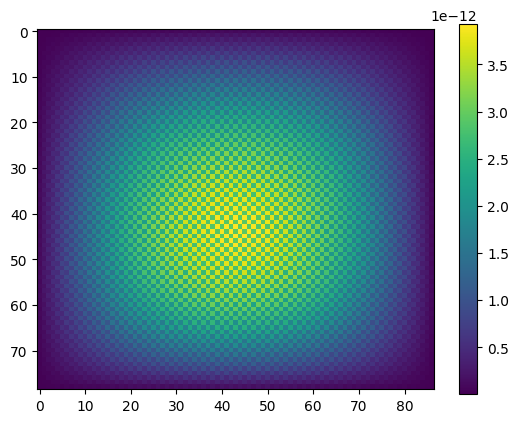

In [13]:
plt.imshow(RV-laplace(psi,*grid_spacing(param)));plt.colorbar()

# Try Hoskins eddy forcing

In [14]:
FGR=2.5
ds.remesh('R64', 'R4', f'R64_R4_FGR{FGR}', operator= lambda x,y: gaussian_remesh(x,y,FGR=FGR))
for file in [f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part1.nc', f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part2.nc']:
    dataset = xr.open_dataset(file, decode_times=False)
    for key in dataset.keys():
        setattr(ds[f'R64_R4_FGR{FGR}'], key, dataset[key])

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR2.5


In [16]:
ref = ds['R64_R4_FGR2.5']

In [27]:
SGSx = ref.SGSx.sel(Time=slice(365*10,None)).isel(zl=0).mean('Time').values
SGSy = ref.SGSy.sel(Time=slice(365*10,None)).isel(zl=0).mean('Time').values
param = ref.param

In [35]:
SGS_vorticity = vorticity(SGSx, SGSy, *grid_spacing(param))
SGS_Hoskins = jacobi_iteration(SGS_vorticity, param) + ref.RV.isel(zl=0,Time=-1)*0

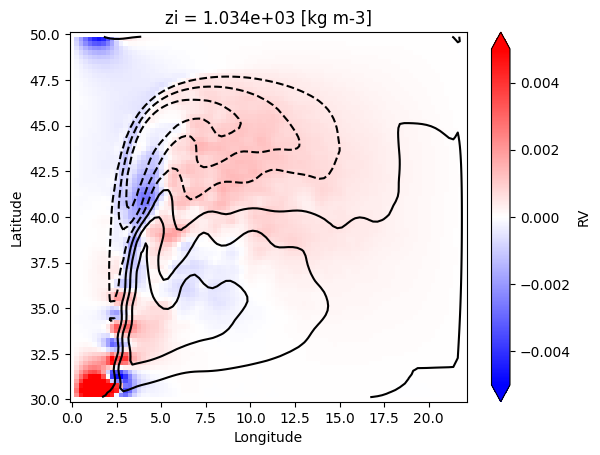

In [48]:
SGS_Hoskins.plot(vmin=-0.005,vmax=0.005, cmap='bwr')
#(SGS_vorticity+ref.RV.isel(zl=0,Time=-1)[1:-1,1:-1]*0).plot(cmap='bwr', vmin=-3e-12,vmax=3e-12)
ref.ssh_mean.plot.contour(levels=np.arange(-5,5,0.5),colors='k')

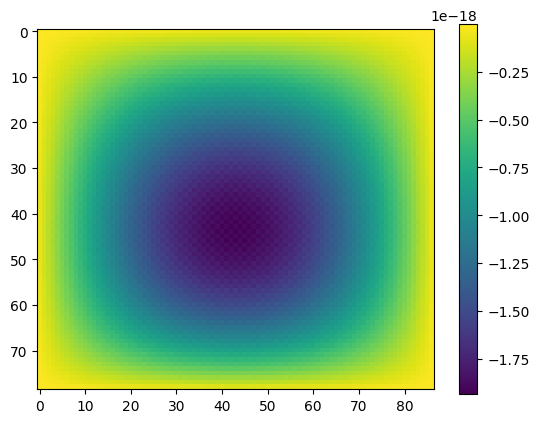

In [57]:
plt.imshow((SGS_vorticity - laplace(SGS_Hoskins.values,*grid_spacing(param)))); plt.colorbar()

# Back to Hughes

In [72]:
SGSx_rot = velocity(SGS_Hoskins.values, *grid_spacing(param))[0] + ds['R4'].u.isel(zl=0,Time=-1)*0

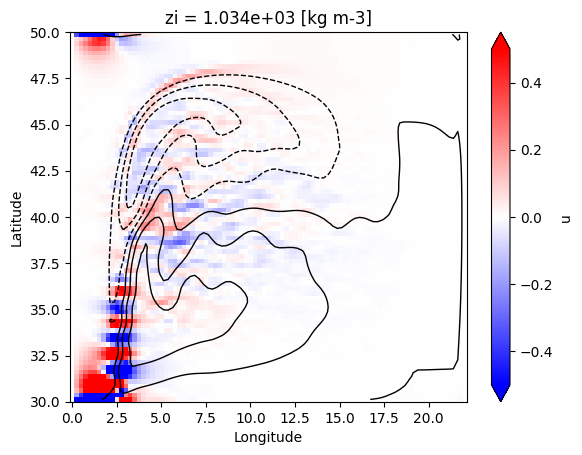

In [89]:
ssh = ref.ssh_mean
levels = np.arange(-4,4.5,0.5)
im = (1e+7*SGSx_rot).plot.imshow(vmin=-0.5, vmax=0.5, cmap='bwr', interpolation='none')
Cplot = ssh.plot.contour(levels=levels, colors='k', linewidths=1)

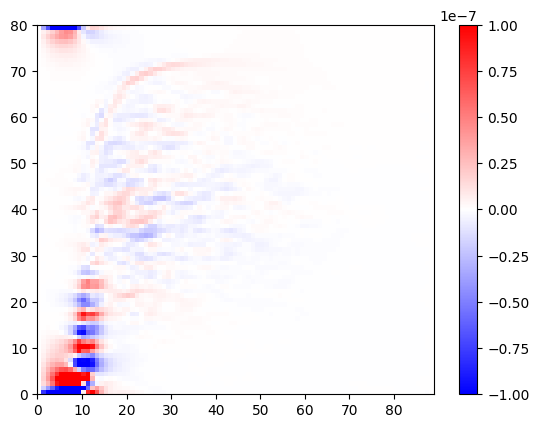

In [86]:
plt.pcolor(velocity(SGS_Hoskins.values, *grid_spacing(param))[0], vmin=-1e-7, vmax=1e-7, cmap='bwr'); plt.colorbar()

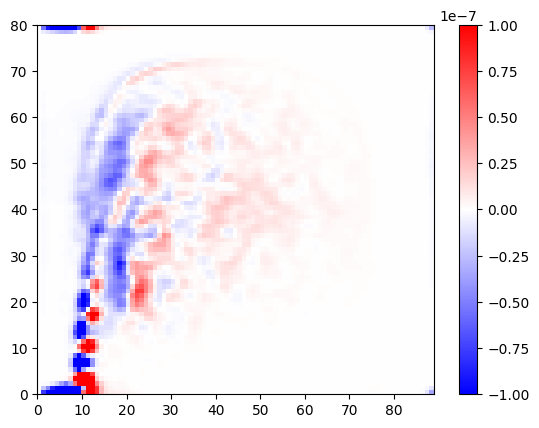

In [87]:
plt.pcolor(SGSx, vmin=-1e-7, vmax=1e-7, cmap='bwr'); plt.colorbar()